In [1]:
import os
os.environ['DGLBACKEND'] = 'pytorch'
import torch
import dgl
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from dgl.dataloading import GraphDataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from dgl.nn import GraphConv
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from torch.optim.lr_scheduler import ReduceLROnPlateau
import netCDF4 as nc

In [2]:

# 读取.nc文件
file_path = "D:/ENSO/features/node_features.nc"
data = nc.Dataset(file_path)

# 读取特征数据
features = data.variables['features'][:]  # 获取特征数据


In [ ]:

# 读取.nc文件
file_path = "D:/ENSO/features/soda_features.nc"
data = nc.Dataset(file_path)

# 读取特征数据
features = data.variables['features'][:]  # 获取特征数据


In [5]:
import xarray as xr

# 读取标签数据

#label_file_path = r'D:\ENSO\data\enso_round1_train_20210201\SODA_label.nc'
label_file_path = r'D:\ENSO\data\enso_round1_train_20210201\CMIP_label.nc'
label_data = xr.open_dataset(label_file_path)

# 提取每年后面24个月的数据
yearly_data = label_data['nino'].values  # 获取原始数据的值
num_years = yearly_data.shape[0]
months_per_year = yearly_data.shape[1]
months_to_keep = 24
# months_to_keep = 12

num_remaining_months = months_per_year - months_to_keep #=12

# 初始化用于存储结果的数组
data_y = np.zeros((num_years, months_to_keep))

for year_idx in range(num_years):
    # 从当前年份的第 (months_to_keep) 个月开始提取数据
    start_month_idx = num_remaining_months#=12
    end_month_idx = start_month_idx + months_to_keep
    
    # 检查当前年份是否有足够的数据
    if end_month_idx <= months_per_year:
        # 提取当前年份后面24个月的数据
        yearly_data_slice = yearly_data[year_idx, start_month_idx:end_month_idx]
    
        # 将提取的数据存储到结果数组中
        data_y[year_idx, :] = yearly_data_slice
    else:
        # 如果当前年份的数据不足24个月，则将剩余位置填充为 0
        data_y[year_idx, :months_per_year - start_month_idx] = yearly_data[year_idx, start_month_idx:]

# 打印结果数组的形状
print("Shape of data_y:", data_y.shape)

Shape of data_y: (4645, 24)


In [7]:
#陆地掩膜
import torch
import xarray as xr
import numpy as np
from global_land_mask import globe

# 假设之前已经有了 generate_land_mask 函数和相关的设置

def create_graph_data(data, land_mask):
    lat_size = len(data['lat'])
    lon_size = len(data['lon'])
    edge_index = create_edges(lat_size, lon_size, land_mask)
    return edge_index

def coordinate_to_node(lat_index, lon_index, lon_size):
    return lat_index * lon_size + lon_index

def generate_land_mask(lon, lat, min_land_area_threshold):
    lon_grid, lat_grid = np.meshgrid(lon - 180, lat)
    
    # Check if a point is on land
    is_on_land = globe.is_land(lat_grid, lon_grid)
    
    # Concatenate is_on_land array across the 180° meridian
    is_on_land = np.concatenate([is_on_land[:, lon >= 180], is_on_land[:, lon < 180]], axis=1)
    
    # Calculate the size of each land area
    from scipy import ndimage
    land_labels, num_features = ndimage.label(is_on_land)
    land_areas = ndimage.sum(is_on_land, land_labels, range(1, num_features + 1))

    # Generate land mask based on area threshold
    land_mask = np.zeros_like(is_on_land, dtype=bool)
    for i in range(1, num_features + 1):
        if land_areas[i - 1] < min_land_area_threshold:
            land_mask[land_labels == i] = False  # Small land areas are considered as ocean
        else:
            land_mask[land_labels == i] = True   # Large land areas are considered as land
    
    return land_mask


def create_edges(lat_size, lon_size, land_mask):
    edge_index = []
    for lat_idx in range(lat_size):
        for lon_idx in range(lon_size):
            node_idx = coordinate_to_node(lat_idx, lon_idx, lon_size)

            # 添加自环
            edge_index.append([node_idx, node_idx])

            # 检查当前节点是否在陆地
            if land_mask[lat_idx, lon_idx]:
                continue  # 如果是陆地，则跳过，不添加边

            # 只添加海洋节点的边
            if lat_idx > 0 and not land_mask[lat_idx - 1, lon_idx]:
                edge_index.append([node_idx, coordinate_to_node(lat_idx - 1, lon_idx, lon_size)])
            if lat_idx < lat_size - 1 and not land_mask[lat_idx + 1, lon_idx]:
                edge_index.append([node_idx, coordinate_to_node(lat_idx + 1, lon_idx, lon_size)])
            if lon_idx > 0 and not land_mask[lat_idx, lon_idx - 1]:
                edge_index.append([node_idx, coordinate_to_node(lat_idx, lon_idx - 1, lon_size)])
            if lon_idx < lon_size - 1 and not land_mask[lat_idx, lon_idx + 1]:
                edge_index.append([node_idx, coordinate_to_node(lat_idx, lon_idx + 1, lon_size)])

            # 添加斜对角线的边（仅在海洋之间）
            if lat_idx > 0 and lon_idx > 0 and not land_mask[lat_idx - 1, lon_idx - 1]:
                edge_index.append([node_idx, coordinate_to_node(lat_idx - 1, lon_idx - 1, lon_size)])
            if lat_idx > 0 and lon_idx < lon_size - 1 and not land_mask[lat_idx - 1, lon_idx + 1]:
                edge_index.append([node_idx, coordinate_to_node(lat_idx - 1, lon_idx + 1, lon_size)])
            if lat_idx < lat_size - 1 and lon_idx > 0 and not land_mask[lat_idx + 1, lon_idx - 1]:
                edge_index.append([node_idx, coordinate_to_node(lat_idx + 1, lon_idx - 1, lon_size)])
            if lat_idx < lat_size - 1 and lon_idx < lon_size - 1 and not land_mask[lat_idx + 1, lon_idx + 1]:
                edge_index.append([node_idx, coordinate_to_node(lat_idx + 1, lon_idx + 1, lon_size)])

    return torch.tensor(edge_index).t().contiguous()

# 读取数据并生成陆地掩膜
train = xr.open_dataset(r'D:\ENSO\data\enso_round1_train_20210201\CMIP_train.nc')
lon = np.array(train.variables['lon'])
lat = np.array(train.variables['lat'])
min_land_area_threshold = 10
land_mask = generate_land_mask(lon, lat, min_land_area_threshold)

# 创建图数据
graph_data = create_graph_data(train, land_mask)
print(graph_data)


tensor([[   0,    0,    0,  ..., 1727, 1727, 1727],
        [   0,   72,    1,  ..., 1655, 1726, 1654]])


In [8]:
graph_data.shape

torch.Size([2, 10918])

In [15]:
#第二种构建边的方式
# 2024年6月10日 17:31:35
import torch
import xarray as xr

def create_graph_data(data):
    lat_size = len(data['lat'])
    lon_size = len(data['lon'])
    edge_index = create_edges(lat_size, lon_size)
    return edge_index

# 将经度、纬度转换为节点编号
def coordinate_to_node(lat_index, lon_index, lon_size):
    return lat_index * lon_size + lon_index

# 构建边索引
def create_edges(lat_size, lon_size):
    edge_index = []
    for lat_idx in range(lat_size):
        for lon_idx in range(lon_size):
            node_idx = coordinate_to_node(lat_idx, lon_idx, lon_size)
            
            edge_index.append([node_idx, node_idx])#增加自环
            
            # 添加上下左右四个方向的边
            if lat_idx > 0:
                edge_index.append([node_idx, coordinate_to_node(lat_idx - 1, lon_idx, lon_size)])
            if lat_idx < lat_size - 1:
                edge_index.append([node_idx, coordinate_to_node(lat_idx + 1, lon_idx, lon_size)])
            if lon_idx > 0:
                edge_index.append([node_idx, coordinate_to_node(lat_idx, lon_idx - 1, lon_size)])
            if lon_idx < lon_size - 1:
                edge_index.append([node_idx, coordinate_to_node(lat_idx, lon_idx + 1, lon_size)])
            
            # 添加斜对角线的边
            if lat_idx > 0 and lon_idx > 0:
                edge_index.append([node_idx, coordinate_to_node(lat_idx - 1, lon_idx - 1, lon_size)])
            if lat_idx > 0 and lon_idx < lon_size - 1:
                edge_index.append([node_idx, coordinate_to_node(lat_idx - 1, lon_idx + 1, lon_size)])
            if lat_idx < lat_size - 1 and lon_idx > 0:
                edge_index.append([node_idx, coordinate_to_node(lat_idx + 1, lon_idx - 1, lon_size)])
            if lat_idx < lat_size - 1 and lon_idx < lon_size - 1:
                edge_index.append([node_idx, coordinate_to_node(lat_idx + 1, lon_idx + 1, lon_size)])

    return torch.tensor(edge_index).t().contiguous()

train = xr.open_dataset(r'D:\ENSO\data\enso_round1_train_20210201\CMIP_train.nc')
graph_data = create_graph_data(train)
print(graph_data)


tensor([[   0,    0,    0,  ..., 1727, 1727, 1727],
        [   0,   72,    1,  ..., 1655, 1726, 1654]])


In [9]:
graph_data.shape

torch.Size([2, 10918])

In [11]:
X_train = torch.tensor(features, dtype=torch.float32)
y_train = data_y

In [13]:
X_train1 = X_train[0:2265, :]  # 提取前 200 条数据的所有特征作为 X_train（现在只提取2266到4645的cmip5的数据，其他为cmip6）
y_train1 = y_train[0:2265, :]  # 假设最后一列是标签，提取前 200 条数据的最后一个特征作为 y_train

#取前面两百条
# X_train1 = X_train[0:151, :]  # 提取前 200 条数据的所有特征作为 X_train（现在只提取2266到4645的cmip5的数据，其他为cmip6）
# y_train1 = y_train[0:151, :]  # 假设最后一列是标签，提取前 200 条数据的最后一个特征作为 y_train

# 确认数据的维度
print("X_train shape:", X_train1.shape)
print("y_train shape:", y_train1.shape)

X_train shape: torch.Size([2265, 1728, 12, 4])
y_train shape: (2265, 24)


In [ ]:
#取前面两百条
X_train1 = X_train[0:75 :]  # 提取前 200 条数据的所有特征作为 X_train（现在只提取2266到4645的cmip5的数据，其他为cmip6）
y_train1 = y_train[0:75, :]  # 假设最后一列是标签，提取前 200 条数据的最后一个特征作为 y_train

# 确认数据的维度
print("X_train shape:", X_train1.shape)
print("y_train shape:", y_train1.shape)

In [15]:
#cmip6数据
import numpy as np
import torch

# 假设 X_train1 和 y_train1 是 NumPy 数组，维度为 (4645, 特征数)
# X_train1 = ...  # 你的数据
# y_train1 = ...  # 你的标签

# 定义模式数量和每个模式的数据条数
num_models = 15
years_per_model = 151  # 每个模型有151年数据

# 初始化列表来存储训练集、验证集和测试集
X_train_list = []
y_train_list = []
X_val_list = []
y_val_list = []
X_test_list = []
y_test_list = []

for model_idx in range(num_models):
    start_idx = model_idx * years_per_model
    end_idx = start_idx + years_per_model
    
    # 提取模型数据
    X_model = X_train1[start_idx:end_idx, :]
    y_model = y_train1[start_idx:end_idx, :]
    
    # 计算索引
    train_end = int(0.8 * years_per_model)
    val_end = train_end + int(0.1 * years_per_model)
    
    # 划分数据
    X_train = X_model[:train_end]
    y_train = y_model[:train_end]
    X_val = X_model[train_end:val_end]
    y_val = y_model[train_end:val_end]
    X_test = X_model[val_end:]
    y_test = y_model[val_end:]
    
    # 存储到列表中
    X_train_list.append(X_train)
    y_train_list.append(y_train)
    X_val_list.append(X_val)
    y_val_list.append(y_val)
    X_test_list.append(X_test)
    y_test_list.append(y_test)

# 将列表转换为 NumPy 数组
X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
X_val = np.concatenate(X_val_list, axis=0)
y_val = np.concatenate(y_val_list, axis=0)
X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

# 转换为 PyTorch 张量
X_train = torch.tensor(X_train, dtype=torch.float32)
# y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
# y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
# y_test = torch.tensor(y_test, dtype=torch.float32)

# 现在你有了训练集、验证集和测试集的 PyTorch 张量
print("训练集大小:", X_train.shape, y_train.shape)
print("验证集大小:", X_val.shape, y_val.shape)
print("测试集大小:", X_test.shape, y_test.shape)


训练集大小: torch.Size([1800, 1728, 12, 4]) (1800, 24)
验证集大小: torch.Size([225, 1728, 12, 4]) (225, 24)
测试集大小: torch.Size([240, 1728, 12, 4]) (240, 24)


In [17]:
from sklearn.model_selection import train_test_split

# 首先划分出测试集（20%），剩余部分为训练集
X_temp, X_test1, y_temp, y_test1 = train_test_split(
    X_train1, y_train1, test_size=0.1, random_state=42
)

# 然后从新的训练集中划分出验证集（10%），剩余部分为新的训练集
X_train1, X_val, y_train1, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1, random_state=42
)

# 输出数据集的形状以确认划分
print("Training set shape:", X_train1.shape, y_train1.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test1.shape, y_test1.shape)


Training set shape: torch.Size([1834, 1728, 12, 4]) (1834, 24)
Validation set shape: torch.Size([204, 1728, 12, 4]) (204, 24)
Test set shape: torch.Size([227, 1728, 12, 4]) (227, 24)


In [37]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
# cmip6
# 假设 X_train 和 y_train 是 NumPy 数组，维度为 (4645, 特征数)
# X_train = ...  # 你的数据
# y_train = ...  # 你的标签

# 定义模式数量和每个模式的数据条数
num_models = 15
years_per_model = 151  # 每个模型有151年数据

# 初始化列表来存储训练集、验证集和测试集
X_train_list = []
y_train_list = []
X_val_list = []
y_val_list = []
X_test_list = []
y_test_list = []

for model_idx in range(num_models):
    start_idx = model_idx * years_per_model
    end_idx = start_idx + years_per_model
    
    # 提取模型数据
    X_model = X_train1[start_idx:end_idx, :]
    y_model = y_train1[start_idx:end_idx, :]
    
    # 先划分出测试集和验证集
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_model, y_model, test_size=0.2, random_state=42
    )
    
    # 从剩下的数据中再划分出验证集
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.2, random_state=42
    )
    
    # 存储到列表中
    X_train_list.append(X_train)
    y_train_list.append(y_train)
    X_val_list.append(X_val)
    y_val_list.append(y_val)
    X_test_list.append(X_test)
    y_test_list.append(y_test)

# 将列表转换为 NumPy 数组
X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
X_val = np.concatenate(X_val_list, axis=0)
y_val = np.concatenate(y_val_list, axis=0)
X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

# 转换为 PyTorch 张量
X_train = torch.tensor(X_train, dtype=torch.float32)
# y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
# y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
# y_test = torch.tensor(y_test, dtype=torch.float32)

# 现在你有了训练集、验证集和测试集的 PyTorch 张量
print("训练集大小:", X_train.shape, y_train.shape)
print("验证集大小:", X_val.shape, y_val.shape)
print("测试集大小:", X_test.shape, y_test.shape)


训练集大小: torch.Size([1440, 1728, 12, 4]) torch.Size([1440, 24])
验证集大小: torch.Size([360, 1728, 12, 4]) torch.Size([360, 24])
测试集大小: torch.Size([465, 1728, 12, 4]) torch.Size([465, 24])


In [19]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
#cmip5
# 设定总的数据量和每个模型的数据量
total_models = 17
model_data_per_model = 140
test_size_per_model = 20

# 初始化列表来存储所有训练数据和测试数据
X_train_final = []
X_test_final = []
y_train_final = []
y_test_final = []

# 遍历每个模型的数据
for model_index in range(total_models):
    # 计算每个模型的数据的开始和结束索引
    start_index = model_index * model_data_per_model
    end_index = start_index + model_data_per_model
    
    # 提取模型的数据
    X_model = X_train[start_index:end_index]
    y_model = y_train[start_index:end_index]
    
    # 划分数据集
    X_train_model, X_test_model, y_train_model, y_test_model = train_test_split(
        X_model, y_model, test_size=test_size_per_model, random_state=42
    )
    
    # 将模型的训练数据和测试数据添加到最终的数据集中
    X_train_final.append(X_train_model)
    X_test_final.append(X_test_model)
    y_train_final.append(y_train_model)
    y_test_final.append(y_test_model)

# 将所有模型的训练数据和测试数据合并，并转换为 torch.Tensor
X_train1 = torch.tensor(np.vstack(X_train_final), dtype=torch.float32).clone().detach()
X_test1 = torch.tensor(np.vstack(X_test_final), dtype=torch.float32).clone().detach()
y_train1 = torch.tensor(np.vstack(y_train_final), dtype=torch.float32).clone().detach()
y_test1 = torch.tensor(np.vstack(y_test_final), dtype=torch.float32).clone().detach()

# 输出数据形状
print("X_train1 shape:", X_train1.shape)
print("X_test1 shape:", X_test1.shape)
print("y_train1 shape:", y_train1.shape)
print("y_test1 shape:", y_test1.shape)


X_train1 shape: torch.Size([2040, 1728, 12, 4])
X_test1 shape: torch.Size([340, 1728, 12, 4])
y_train1 shape: torch.Size([2040, 24])
y_test1 shape: torch.Size([340, 24])


In [19]:
graphs_train = []
graphs_train.append(graph_data)

In [17]:
graph_size = 1
input_size = 4
seq_length = 12
hidden_size = 12
batch_size = 1
num_classes = 24 * batch_size
num_layers = 1
nodes_num = 1728
final_hidden_size = 24


In [19]:
'''构造特征值和标签'''
from torch.utils.data import DataLoader,TensorDataset,Dataset
class GraphDataset(Dataset): 
    def __init__(self, graph_list, label_list): 
        """ :param graph_list: A list of DGLGraph objects :param label_file: A file containing labels for the graphs """ 
        self.graph_list = graph_list 
        self.labels = label_list
    def __len__(self): 
        return len(self.graph_list) 
    def __getitem__(self, idx): 
        graph = self.graph_list[idx]
        label = torch.tensor(self.labels[idx],dtype=torch.float32)
        # label = self.labels[idx].clone().detach()  # Ensure no warning by using .clone().detach()
        return graph, label 
    
def collate_fn(batch):
    graphs, labels = zip(*batch)
    batched_graph = dgl.batch(graphs) 
    labels = torch.stack(labels, 0).reshape(-1)
    
    return batched_graph, labels

graph_data_np = graph_data.numpy()

graphs_train = []
graphs_label = []
for X,Y in zip(X_train1,y_train1):
    g = dgl.graph((graph_data_np[0], graph_data_np[1]))
    g.ndata['feature'] = X
    graphs_label.append(Y)
    graphs_train.append(g)
dataset = GraphDataset(graphs_train,graphs_label)
loader_train = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False,collate_fn=collate_fn)

In [25]:
def rearrange_data(h):
    num_nodes = h.shape[0]
    num_features = h.shape[1]
    grid_rows = 24
    grid_cols = 72
    total_nodes = grid_rows * grid_cols
    
    # 创建一个适当大小的零张量
    rearranged_data = torch.zeros(num_features, grid_rows, grid_cols, dtype=h.dtype, device=h.device)
    
    # 遍历每个节点的数据，按照节点编号和特征维度填充到新的张量中
    for node_idx in range(total_nodes):
        # 计算在 24x72 的二维网格中的坐标
        row = node_idx // grid_cols
        col = node_idx % grid_cols
        
        # 如果 node_idx 超过了 h 的大小，跳出循环
        if node_idx >= num_nodes:
            break
        
        # 将节点的特征数据填充到对应的位置
        with torch.no_grad():
            rearranged_data[:, row, col] = h[node_idx]
    
    return rearranged_data


In [ ]:
class processing(nn.Module):  #使用不同的方式来处理数据，普通lstm使用Linear,这里使用GCN。
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.fn = GraphConv(input_size,hidden_size) #使用GCN
    def forward(self, g, feat):   #feat:(nodes_num,feature_len)nodes_num = 6912
        feat = self.fn(g, feat)
        feat = F.elu(feat)     #ELU激活函数，可以选择不使用
        return feat
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.forget_gate = processing(input_size + hidden_size, hidden_size)
        self.input_gate = processing(input_size + hidden_size, hidden_size)
        self.output_gate = processing(input_size + hidden_size, hidden_size)
        self.cell_gate = processing(input_size + hidden_size, hidden_size)
    
    def forward(self,g, feature, hidden):
        h_prev, c_prev = hidden
        combined = torch.cat((feature, h_prev), dim=1)
        
        f_t = torch.sigmoid(self.forget_gate(g,combined))
        i_t = torch.sigmoid(self.input_gate(g,combined))
        o_t = torch.sigmoid(self.output_gate(g,combined))
        c_tilde = torch.tanh(self.cell_gate(g,combined))
        
        c_t = f_t * c_prev + i_t * c_tilde
        # h_t = o_t * torch.tanh(c_t)
        h_t = o_t * torch.tanh(c_t) + h_prev  # 2024-9-28-11.00添加残差连接
        
        return h_t, c_t
    
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm_cells = nn.ModuleList([LSTMCell(input_size, hidden_size) if i == 0 else LSTMCell(hidden_size, hidden_size) for i in range(num_layers)])
    
    def forward(self, g,feature,state):
        batch_size, seq_length, _ = feature.size()
        if not state :                 #初始化h,c状态
            h = [torch.zeros(batch_size, self.hidden_size).to(feature.device) for _ in range(self.num_layers)]
            c = [torch.zeros(batch_size, self.hidden_size).to(feature.device) for _ in range(self.num_layers)]
        else:
            h,c = state
        
        #outputs = []
        for t in range(seq_length):
            input_t = feature[:, t, :]
            for layer in range(self.num_layers):
                h[layer], c[layer] = self.lstm_cells[layer](g,input_t, (h[layer], c[layer]))
                input_t = h[layer]
            #outputs.append(h[-1])  #这里我们只需要使用最后的h作为结果，如果需要用到所有结果再进行处理，则需要这样存储起来
        
        #outputs = torch.stack(outputs, dim=1)
        return h[-1], (h, c)
class GCN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size,num_classes,num_layers,final_hidden_size):
        super().__init__()
        self.Encoder = LSTM(input_size,hidden_size,num_layers) 
        #解码器需要重新定义
        self.Decoder = nn.Linear(hidden_size,num_classes)
        self.layer_norm=nn.LayerNorm(hidden_size,elementwise_affine=False)
        #self.weight = nn.Parameter(torch.ones(1,nodes_num*batch_size)/nodes_num*batch_size)
        self.conva = nn.Conv2d(in_channels = 12 , out_channels = 18, kernel_size =7 , dilation =  2)
        self.convb = nn.Conv2d(in_channels = 18 , out_channels = 24, kernel_size =3 , dilation =  2)
        #self.convc = nn.Conv2d(in_channels = 4 , out_channels = 1, kernel_size =3 , dilation =  2)
        self.pool1 = nn.AdaptiveAvgPool2d((1, 1))
        #nn.init.xavier_uniform_(self.weight,gain = 1.414)
    def forward(self, g, feat,state):   #feat:(nodes_num,feature_len)
        h,state = self.Encoder(g,feat,state)
        h = F.elu(h)     #ELU激活函数，可以选择不使用
        h = self.layer_norm(h)
        h = rearrange_data(h) #h.shape = 1*12*24*72
        h = self.conva(h)
        h = self.convb(h)
        h = self.pool1(h)
        #矩阵只有当左边矩阵的列数等于右边矩阵的行数时,它们才可以相乘,乘积矩阵的行数等于左边矩阵的行数,乘积矩阵的列数等于右边矩阵的列数
        # self.weight = [1,1728]    h.shape = [1728*12] 
        #h_graph = torch.matmul(self.weight, h)
        #h_graph.shape=([1, 12])
        #h_graph = self.final_linear(h_graph)  
        #h_graph = self.Decoder(h_graph)#1*24
        return h,state

In [21]:
class processing(nn.Module):  #使用不同的方式来处理数据，普通lstm使用Linear,这里使用GCN。
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.fn = GraphConv(input_size,hidden_size) #使用GCN
#         使用mixhop ： self.linear = nn.Linear(hidden_size*3,hidden_size)
    def forward(self, g, feat):   #feat:(nodes_num,feature_len)nodes_num = 6912
        feat = self.fn(g, feat)
#         使用mixhop：feat = self.linear(feat)
        feat = F.elu(feat)     #ELU激活函数，可以选择不使用
        return feat
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.forget_gate = processing(input_size + hidden_size, hidden_size)
        self.input_gate = processing(input_size + hidden_size, hidden_size)
        self.output_gate = processing(input_size + hidden_size, hidden_size)
        self.cell_gate = processing(input_size + hidden_size, hidden_size)
    
    def forward(self,g, feature, hidden):
        h_prev, c_prev = hidden
        combined = torch.cat((feature, h_prev), dim=1)
        
        f_t = torch.sigmoid(self.forget_gate(g,combined))
        i_t = torch.sigmoid(self.input_gate(g,combined))
        o_t = torch.sigmoid(self.output_gate(g,combined))
        c_tilde = torch.tanh(self.cell_gate(g,combined))
        
        c_t = f_t * c_prev + i_t * c_tilde
        h_t = o_t * torch.tanh(c_t)
        # h_t = o_t * torch.tanh(c_t) + h_prev
        
        return h_t, c_t
    
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm_cells = nn.ModuleList([LSTMCell(input_size, hidden_size) if i == 0 else LSTMCell(hidden_size, hidden_size) for i in range(num_layers)])
    
    def forward(self, g,feature,state):
        batch_size, seq_length, _ = feature.size()
        if not state :                 #初始化h,c状态
            h = [torch.zeros(batch_size, self.hidden_size).to(feature.device) for _ in range(self.num_layers)]
            c = [torch.zeros(batch_size, self.hidden_size).to(feature.device) for _ in range(self.num_layers)]
        else:
            h,c = state
        
        #outputs = []
        for t in range(seq_length):
            input_t = feature[:, t, :]
            for layer in range(self.num_layers):
                h[layer], c[layer] = self.lstm_cells[layer](g,input_t, (h[layer], c[layer]))
                input_t = h[layer]
            #outputs.append(h[-1])  #这里我们只需要使用最后的h作为结果，如果需要用到所有结果再进行处理，则需要这样存储起来
        
        #outputs = torch.stack(outputs, dim=1)
        return h[-1], (h, c)
class GCN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size,num_classes,num_layers,final_hidden_size):
        super().__init__()
        self.Encoder = LSTM(input_size,hidden_size,num_layers) 
        #解码器需要重新定义
        self.Decoder = nn.Linear(hidden_size,num_classes)
        self.layer_norm=nn.LayerNorm(hidden_size,elementwise_affine=False)
        self.weight = nn.Parameter(torch.ones(1,nodes_num*batch_size)/nodes_num*batch_size)
    
        
        #nn.init.xavier_uniform_(self.weight,gain = 1.414)
    def forward(self, g, feat,state):   #feat:(nodes_num,feature_len)
        h,state = self.Encoder(g,feat,state)        #print(h.shape)=1728.12
        h = F.elu(h)     #ELU激活函数，可以选择不使用
        h = self.layer_norm(h)
        

        #矩阵只有当左边矩阵的列数等于右边矩阵的行数时,它们才可以相乘,乘积矩阵的行数等于左边矩阵的行数,乘积矩阵的列数等于右边矩阵的列数
#         self.weight = [1,1728]    h.shape = [1728*12] 
        h_graph = torch.matmul(self.weight, h)
        #h_graph.shape=([1, 12])
        #h_graph = self.final_linear(h_graph)  
        h_graph = self.Decoder(h_graph)#1*24
        return h_graph,state

In [28]:
# 自适应权重（torch.exp(-abs_errors)）来生成权重，意味着较大的误差会被赋予较低的权重，而较小的误差会被赋予较高的权重。
import torch
import torch.nn as nn

class AdaptiveWeightedMSELoss(nn.Module):
    def __init__(self, initial_weights):
        super().__init__()
        self.initial_weights = initial_weights
        
    def forward(self, output, target):
        # 确保目标和输出在同一设备上
        output = output.to(self.initial_weights.device)
        target = target.to(self.initial_weights.device)
        
        # 计算预测误差
        errors = output - target
        
        # 计算自适应权重：根据预测误差调整权重
        abs_errors = torch.abs(errors)
        adaptive_weights = torch.exp(abs_errors)  # 这里使用了指数衰减函数作为示例
        
        # 归一化自适应权重
        adaptive_weights = adaptive_weights / (adaptive_weights.sum() + 1e-8)  # 避免除零错误
        
        # 计算加权均方误差
        loss = torch.mean(adaptive_weights * errors ** 2)
        return loss

# 总月份数
num_months = 24

# 高斯函数的均值和标准差
mu = (num_months - 1) / 2
sigma = num_months / 6

# 计算高斯权重
indices = torch.arange(num_months)
initial_weights = torch.exp(-((indices - mu) ** 2) / (2 * sigma ** 2))

# 设置权重下限，避免权重过低
min_weight = 1e-5
initial_weights = torch.clamp(initial_weights, min=min_weight)

# 归一化权重以确保其和为1
initial_weights /= initial_weights.sum()

# 将权重转换到设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
initial_weights = initial_weights.to(device)

# 初始化自适应损失函数
criterion = AdaptiveWeightedMSELoss(initial_weights)


In [33]:
import torch
import torch.nn as nn

class AdaptiveWeightedMSELoss(nn.Module):
    def __init__(self, initial_weights):
        super().__init__()
        self.initial_weights = initial_weights
        
    def forward(self, output, target):
        # 确保目标和输出在同一设备上
        output = output.to(self.initial_weights.device)
        target = target.to(self.initial_weights.device)
        
        # 计算预测误差
        errors = output - target
        
        # 计算自适应权重：根据预测误差调整权重
        abs_errors = torch.abs(errors)
        adaptive_weights = torch.exp(abs_errors)  # 这里使用了指数衰减函数作为示例
        
        # 归一化自适应权重
        adaptive_weights = adaptive_weights / (adaptive_weights.sum() + 1e-8)  # 避免除零错误
        
        # 计算加权均方误差
        loss = torch.mean(adaptive_weights * errors ** 2)
        return loss

# 总月份数
num_months = 24

# 初始化权重为所有月份的平均值
average_value = 1.0 / num_months
weights = torch.full((num_months,), average_value, dtype=torch.float32)

# 归一化权重以确保其和为1
weights /= weights.sum()

# 将权重转换到设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = weights.to(device)

# 初始化自适应损失函数
criterion = AdaptiveWeightedMSELoss(weights)


In [ ]:
class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.weights = weights
    
    def forward(self, output, target):
        batch_size = output.size(0)
        loss = torch.mean(self.weights * (output - target) ** 2)
        return loss

# 总月份数
num_months = 24

# 设计线性递减权重
base_weights = 1.0 - torch.arange(num_months) / (num_months - 1)

# 增强六月到十四月的权重
enhanced_weights = base_weights.clone()
enhanced_weights[5:14] *= 4  # 增强4倍

# 设置权重下限，避免权重过低
min_weight = 1e-5
enhanced_weights = torch.clamp(enhanced_weights, min=min_weight)

# 提升第十个月到第十六个月的权重两倍
enhanced_weights[9:16] *= 2  # 提升2倍

# 归一化权重以确保其和为1
enhanced_weights /= enhanced_weights.sum()

# 将权重转换到设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
month_weights = enhanced_weights.to(device)

# 初始化自定义损失函数
criterion = WeightedMSELoss(month_weights)


In [23]:
val_graphs_label1 = []
val_graphs_test1 = []
#构造验证集合
for X,Y in zip(X_val,y_val):
    g = dgl.graph((graph_data_np[0], graph_data_np[1]))
    g.ndata['feature'] = X
    val_graphs_label1.append(Y)
    val_graphs_test1.append(g)
dataset = GraphDataset(val_graphs_test1,val_graphs_label1)
loader_val = DataLoader(dataset, batch_size=1, shuffle=False, drop_last=False,collate_fn=collate_fn)



In [ ]:
# self, input_size, hidden_size,num_classes,num_layers,final_hidden_size
model = GCN_LSTM(input_size, hidden_size, num_classes, 2, final_hidden_size).to(device)

state = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss() 
out_list = []
labels_list = []

best_loss = float('inf')  # 初始化为正无穷
for epoch in range(50):  # 总共训练 60 次
    model.train()
    losses = []  # 用于收集每个批次的损失值
    for batch in loader_train:
        for S in state:
            for s in S:
                s.detach_()  
                
        input_data, labels = batch
        input_data = input_data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        out, state = model(input_data, input_data.ndata['feature'], state)
        out = out.squeeze()
#         loss = criterion(out, labels)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())  # 存储本批次的损失
        
        # 收集out和labels的数据
        out_list.append(out.detach().cpu().numpy())
        labels_list.append(labels.detach().cpu().numpy())
     
    # 计算本轮epoch的平均损失 
    avg_loss = np.mean(losses)
    
    # 如果已经训练了 40 次，就将学习率调整为更小的值
    if epoch == 60:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.008)  # 将学习率调整为 0.0005
    
    # 如果本轮epoch的平均损失低于之前记录的最低损失，则更新最低损失值并保存模型
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), 'best_model.pt')
    
    # 打印本轮epoch的平均损失以及最后一个批次的损失
    print(f'Epoch [{epoch+1}], train-Loss: {avg_loss}, last batch loss: {loss.item()}')


Epoch [1], train-Loss: 0.8763725189492106, last batch loss: 0.5067700147628784
Epoch [2], train-Loss: 0.6202195816393942, last batch loss: 0.7611602544784546
Epoch [3], train-Loss: 0.603362712841481, last batch loss: 1.4470131397247314
Epoch [4], train-Loss: 0.5022507557831705, last batch loss: 0.7933434844017029
Epoch [5], train-Loss: 0.4975692902319133, last batch loss: 0.5320953130722046
Epoch [6], train-Loss: 0.4605277467565611, last batch loss: 0.4972069263458252
Epoch [7], train-Loss: 0.4322959861904383, last batch loss: 0.4238414764404297
Epoch [8], train-Loss: 0.5778091005375608, last batch loss: 0.4819154441356659
Epoch [9], train-Loss: 0.629165186197497, last batch loss: 1.5397815704345703
Epoch [10], train-Loss: 0.7128876999043859, last batch loss: 0.46635136008262634
Epoch [11], train-Loss: 0.4324768865806982, last batch loss: 0.7156438231468201
Epoch [12], train-Loss: 0.38983117558993396, last batch loss: 0.47768837213516235
Epoch [13], train-Loss: 0.3757216034643352, last

In [139]:
#inputsize= 4  hidden_size= 12
# class processing(nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super().__init__()
#         # a = int(hidden_size)  # 强制转换为整数
#         self.fn1 = GraphConv(input_size, 16)
#         self.fn2 = GraphConv(16, 32)  # 这里可能需要根据实际情况调整
#         self.fn3 = GraphConv(32, 64)  # 同上
#         self.linear = nn.Linear(16+32+64, hidden_size)
#         self.relu = nn.GELU()
#     def forward(self, g, feat):
#         feat1 = self.fn1(g, feat)
#         feat1 = self.relu(feat1)
#         feat2 = self.fn2(g, feat1)
#         feat2 = self.relu(feat2)
#         feat3 = self.fn3(g, feat2)
#         feat3 = self.relu(feat3)
#         feat = torch.cat((feat1, feat2, feat3), dim=1)
#         feat = self.linear(feat)
#         return feat
class processing(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.fn1 = GraphConv(input_size, 16)
        self.bn1 = nn.BatchNorm1d(16)  # 添加批归一化层
        self.fn2 = GraphConv(16 + input_size, 32)
        self.bn2 = nn.BatchNorm1d(32)  # 添加批归一化层
        self.fn3 = GraphConv(32 + input_size + 16, 64)
        self.bn3 = nn.BatchNorm1d(64)  # 添加批归一化层
        self.linear = nn.Linear(16 + 32 + 64, hidden_size)
        self.relu = nn.GELU()

    def forward(self, g, feat):
        original_feat = feat  # 保存最原始的输入特征
        
        feat1 = self.fn1(g, feat)
        # feat1 = self.bn1(feat1)  # 添加批归一化
        feat1 = self.relu(feat1)
        
        feat2 = self.fn2(g, torch.cat((feat1, original_feat), dim=1))
        # feat2 = self.bn2(feat2)  # 添加批归一化
        feat2 = self.relu(feat2)
        
        feat3 = self.fn3(g, torch.cat((feat2, feat1, original_feat), dim=1))
        feat3 = self.bn3(feat3)  # 添加批归一化
        feat3 = self.relu(feat3)
        
        feat = torch.cat((feat1, feat2, feat3), dim=1)
        feat = self.linear(feat)
        return feat


class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.forget_gate = processing(input_size + hidden_size, hidden_size)
        self.input_gate = processing(input_size + hidden_size, hidden_size)
        self.output_gate = processing(input_size + hidden_size, hidden_size)
        self.cell_gate = processing(input_size + hidden_size, hidden_size)
    
    def forward(self,g, feature, hidden):
        h_prev, c_prev = hidden
        combined = torch.cat((feature, h_prev), dim=1)
        
        f_t = torch.sigmoid(self.forget_gate(g,combined))
        i_t = torch.sigmoid(self.input_gate(g,combined))
        o_t = torch.sigmoid(self.output_gate(g,combined))
        c_tilde = torch.tanh(self.cell_gate(g,combined))
        
        c_t = f_t * c_prev + i_t * c_tilde
        h_t = o_t * torch.tanh(c_t)
        # h_t = o_t * torch.tanh(c_t) + h_prev
        
        return h_t, c_t
    
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm_cells = nn.ModuleList([LSTMCell(input_size, hidden_size) if i == 0 else LSTMCell(hidden_size, hidden_size) for i in range(num_layers)])
    
    def forward(self, g,feature,state):
        batch_size, seq_length, _ = feature.size()
        if not state :                 #初始化h,c状态
            h = [torch.zeros(batch_size, self.hidden_size).to(feature.device) for _ in range(self.num_layers)]
            c = [torch.zeros(batch_size, self.hidden_size).to(feature.device) for _ in range(self.num_layers)]
        else:
            h,c = state
        
        #outputs = []
        for t in range(seq_length):
            input_t = feature[:, t, :]
            for layer in range(self.num_layers):
                h[layer], c[layer] = self.lstm_cells[layer](g,input_t, (h[layer], c[layer]))
                input_t = h[layer]
            #outputs.append(h[-1])  #这里我们只需要使用最后的h作为结果，如果需要用到所有结果再进行处理，则需要这样存储起来
        
        #outputs = torch.stack(outputs, dim=1)
        return h[-1], (h, c)
class GCN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size,num_classes,num_layers,final_hidden_size):
        super().__init__()
        self.Encoder = LSTM(input_size,hidden_size,num_layers) 
        #解码器需要重新定义
        self.Decoder = nn.Linear(hidden_size,num_classes)
        self.layer_norm=nn.LayerNorm(hidden_size,elementwise_affine=False)
        self.weight = nn.Parameter(torch.ones(1,nodes_num*batch_size)/nodes_num*batch_size)
    
        
        #nn.init.xavier_uniform_(self.weight,gain = 1.414)
    def forward(self, g, feat,state):   #feat:(nodes_num,feature_len)
        h,state = self.Encoder(g,feat,state)        #print(h.shape)=1728.12
        h = F.elu(h)     #ELU激活函数，可以选择不使用
        h = self.layer_norm(h)
        

        #矩阵只有当左边矩阵的列数等于右边矩阵的行数时,它们才可以相乘,乘积矩阵的行数等于左边矩阵的行数,乘积矩阵的列数等于右边矩阵的列数
#         self.weight = [1,1728]    h.shape = [1728*12] 
        h_graph = torch.matmul(self.weight, h)
        #h_graph.shape=([1, 12])
        #h_graph = self.final_linear(h_graph)  
        h_graph = self.Decoder(h_graph)#1*24
        return h_graph,state

In [25]:
model = GCN_LSTM(input_size, hidden_size, num_classes, 3, final_hidden_size).to(device)
#  def __init__(self, input_size, hidden_size,num_classes,num_layers,final_hidden_size):
state = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss() 
out_list = []
labels_list = []
#使用策略调整学习率
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=8)

best_loss = float('inf')  # 初始化为正无穷
for epoch in range(50):  # 总共训练 60 次
    model.train()
    losses = []  # 用于收集每个批次的损失值
    for batch in loader_train:
        for S in state:
            for s in S:
                s.detach_()  
                
        input_data, labels = batch
        input_data = input_data.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        out, state = model(input_data, input_data.ndata['feature'], state)
        out = out.squeeze()

        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())  # 存储本批次的损失
        
        # 收集out和labels的数据
        out_list.append(out.detach().cpu().numpy())
        labels_list.append(labels.detach().cpu().numpy())
     
    # 计算本轮epoch的平均损失 
    avg_loss = np.mean(losses)
    
    # # 如果已经训练了 30 次，就将学习率调整为更小的值
    # if epoch == 40:
    #     optimizer = torch.optim.Adam(model.parameters(), lr=0.005)  # 将学习率调整为 0.01
    
    # 验证阶段
    model.eval()  # 切换到评估模式
    val_losses = []  # 用于存储验证损失
    with torch.no_grad():  # 禁用梯度计算
        for val_batch in loader_val:  # 假设你有一个验证数据加载器
            val_input_data, val_labels = val_batch
            val_input_data = val_input_data.to(device)
            val_labels = val_labels.to(device)
            val_out, _ = model(val_input_data, val_input_data.ndata['feature'], state)
            val_out = val_out.squeeze()
            val_loss = criterion(val_out, val_labels)
            val_losses.append(val_loss.item())
    
    avg_val_loss = np.mean(val_losses)  # 计算验证集的平均损失

    # 更新学习率
    scheduler.step(avg_val_loss)  # 根据验证损失更新学习率
    # 如果本轮epoch的平均损失低于之前记录的最低损失，则更新最低损失值并保存模型
    current_lr = scheduler.get_last_lr()[0]  # 通常情况下，我们只需查看第一个参数
    print(f'Current Learning Rate: {current_lr}')
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pt')
    
    # 打印本轮epoch的平均损失以及最后一个批次的损失
    print(f'Epoch [{epoch+1}], train-Loss: {avg_loss}, validation-Loss: {avg_val_loss}, last batch loss: {loss.item()}')


Current Learning Rate: 0.001
Epoch [1], train-Loss: 0.6605837386200167, validation-Loss: 0.8019366571803888, last batch loss: 0.5869218707084656
Current Learning Rate: 0.001
Epoch [2], train-Loss: 0.5681090122438293, validation-Loss: 0.7007688482354084, last batch loss: 0.7964266538619995
Current Learning Rate: 0.001
Epoch [3], train-Loss: 0.5335786074276594, validation-Loss: 0.6606178011745214, last batch loss: 0.6211901903152466
Current Learning Rate: 0.001
Epoch [4], train-Loss: 0.5184274658647101, validation-Loss: 0.6490404692954487, last batch loss: 0.5591058135032654
Current Learning Rate: 0.001
Epoch [5], train-Loss: 0.5090396577521139, validation-Loss: 0.6468755131049289, last batch loss: 0.5210593342781067
Current Learning Rate: 0.001
Epoch [6], train-Loss: 0.5010820134364019, validation-Loss: 0.6463099272631937, last batch loss: 0.5070700645446777
Current Learning Rate: 0.001
Epoch [7], train-Loss: 0.4956289376931935, validation-Loss: 0.6448618170039522, last batch loss: 0.50

In [115]:
 save_path = r'D:\轻松的研二\ENSO\预测二十四个月的模型.pth'
torch.save(model.state_dict(), save_path)  # 保存模型权重
print(f'Model saved to {save_path}')

Model saved to D:\轻松的研二\ENSO\预测二十四个月的模型.pth


In [61]:
model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [43]:
# 计算模型的总参数量
# model = GCN_LSTM(input_size, hidden_size, num_classes, 3, final_hidden_size).to(device)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Total number of parameters: {total_params}')

Total number of parameters: 5256


In [ ]:
X_test1 = X_train[75:100, :]
y_test1 = y_train[75:100, :]


In [ ]:
# X_train_split, X_test_split = X_train_sample[:train_size], X_train_sample[train_size:]
# y_train_split, y_test_split = y_train_sample[:train_size], y_train_sample[train_size:]
print("测试集大小:", X_test.shape, y_test.shape)

In [31]:
graphs_label1 = []
graphs_test1 = []
#构造测试集
for X,Y in zip(X_test,y_test):
    g = dgl.graph((graph_data_np[0], graph_data_np[1]))
    g.ndata['feature'] = X
    graphs_label1.append(Y)
    graphs_test1.append(g)
dataset = GraphDataset(graphs_test1,graphs_label1)
loader_test = DataLoader(dataset, batch_size=1, shuffle=False, drop_last=False,collate_fn=collate_fn)

In [47]:
best_model_path = r'D:\轻松的研二\实验结果\全_+自适应+划分+50次0.01+best_model.pt'
model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

In [33]:
model.load_state_dict(torch.load('best_model.pt'))
model.to(device)  # 确保模型在正确的设备上

criterion = torch.nn.MSELoss() 
model.eval()  # 设置模型为测试模式

out_list_test = []
labels_list_test = []
test_losses = []  # 用于收集每个批次的测试损失值

# 初始化 state

for batch in loader_test:
    for S in state:
        for s in S:
            s.detach_()

    input_data, labels = batch
    input_data = input_data.to(device)

    with torch.no_grad():  # 在测试阶段不需要计算梯度
        out, state = model(input_data, input_data.ndata['feature'], state)
        out = out.squeeze()
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    out = out.to(device)
    labels = labels.to(device)
    # 计算测试损失
    test_loss = criterion(out, labels)
    test_losses.append(test_loss.item())

    # 收集out和labels的数据
    out_list_test.append(out.detach().cpu().numpy())
    labels_list_test.append(labels.detach().cpu().numpy())

# 计算整体测试损失
avg_test_loss = np.mean(test_losses)
print(f'Test-Loss: {avg_test_loss}')


Test-Loss: 0.6850516819821981


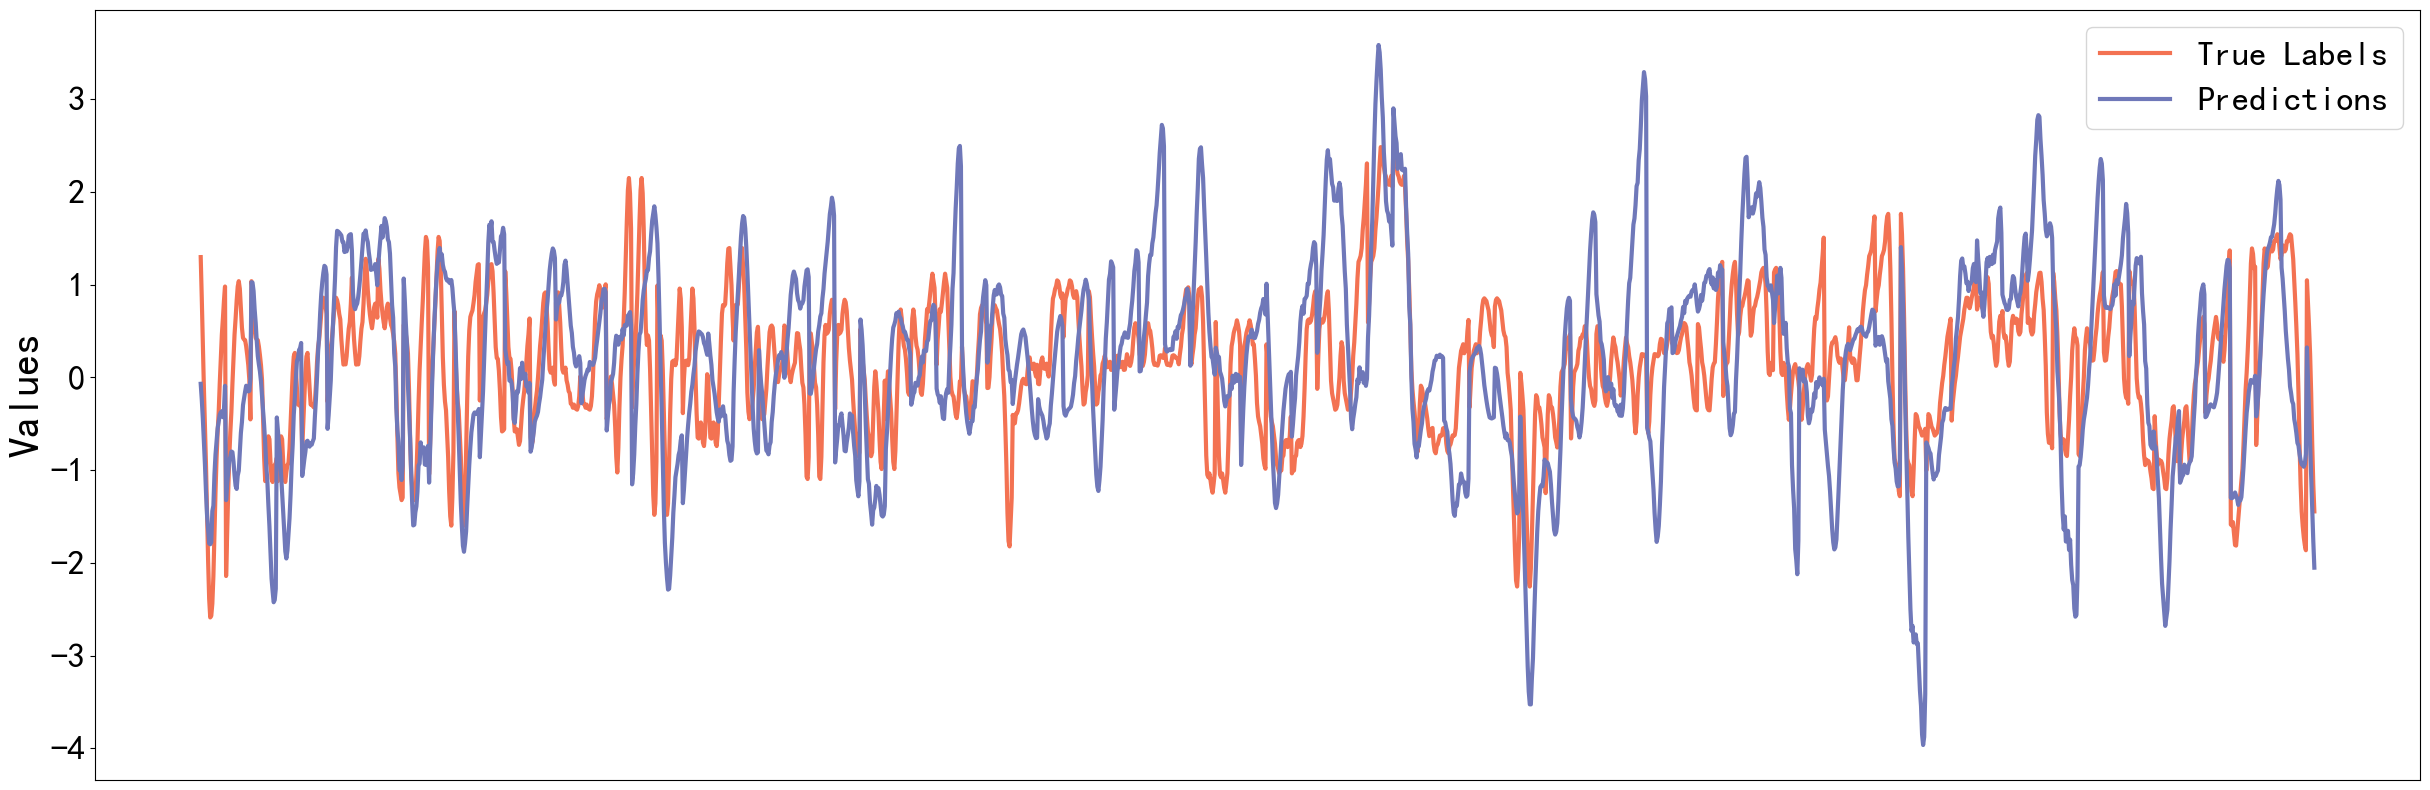

In [135]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置字体为黑体（SimHei）
rcParams['font.family'] = 'SimHei'  # 设置字体为黑体
rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
out_test_flat = np.concatenate(out_list_test, axis=0)
labels_test_flat = np.concatenate(labels_list_test, axis=0)

# 只取前1000条数据
out_test_flat = out_test_flat[:2000]
labels_test_flat = labels_test_flat[:2000]

# RGB颜色转换为[0, 1]区间
color_true_labels = (243/255, 114/255, 82/255)  # R248G230B032
color_predictions = (111/255, 120/255, 185/255)  # R053G183B119
# 修改为 R048G104B141
line_color = (48/255, 104/255, 141/255)  # R048G104B141

# 绘制预测值与真实标签对比图
plt.figure(figsize=(30, 10))

# 绘制真实标签
plt.plot(labels_test_flat, label='True Labels', color=color_true_labels, alpha=1, linewidth=3)

# 绘制预测结果
plt.plot(out_test_flat, label='Predictions', color=color_predictions, alpha=1, linewidth=3)

# 添加图例并加粗字体，增大字体大小，设置图例位置为右上角，避免遮挡图像
plt.legend(prop={'size': 25, 'weight': 'bold'}, loc='upper right', bbox_to_anchor=(1, 1))  # 设置图例在右上角，避免遮挡

# 添加标题和标签
# plt.title('one month', fontsize=30)  # 增大标题字体并加粗
# plt.xlabel('Samples', fontsize=30)  # 如果不需要x轴标签的话，注释掉此行
plt.ylabel('Values', fontsize=30)  # 增大纵坐标标签字体并加粗

# 增大竖轴刻度字体大小
plt.tick_params(axis='y', labelsize=25)  # 设置y轴刻度标签的字体大小为25

# 禁用横坐标的刻度标签
plt.xticks([])  # 不显示横坐标的刻度标签

# 设置图像保存路径和文件名
save_path = r'D:\轻松的研二\ENSO\预测真实数据十二个月的测试图片.png'

# 保存图片
plt.savefig(save_path, dpi=300, bbox_inches='tight')  # 使用高质量保存图像

# 显示图形
plt.show()


In [71]:
model.eval()  # 设置模型为测试模式

out_list_test = []
labels_list_test = []

for batch in loader_test:
    for S in state:
        for s in S:
            s.detach_()

    input_data, labels = batch
    input_data = input_data.to(device)

    with torch.no_grad():  # 在测试阶段不需要计算梯度
        out, state = model(input_data, input_data.ndata['feature'], state)
        out = out.squeeze()

    # 收集out和labels的数据
    out_list_test.append(out.detach().cpu().numpy())
    labels_list_test.append(labels.detach().cpu().numpy())


C:\Users\lyh\AppData\Local\Temp\ipykernel_18636\3689365157.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.labels[idx],dtype=torch.float32)


In [37]:
import matplotlib.pyplot as plt
for i in range(len(out_list_test), len(labels_list_test)):
    plt.figure()  # 为每个迭代周期创建一个新图表
    plt.title(f'Testing Curve - Epoch {i+1}')
    plt.plot(out_list_test[i], label='out')
    plt.plot(labels_list_test[i], label='labels')
    plt.legend()
    plt.show()

In [37]:
# 初始化月度皮尔逊相关系数列表
pearson_coefficients_monthly = []

# 逐一计算每个月的皮尔逊相关系数
for month in range(24):
    # 提取每个月的预测值和标签
    out_month = [row[month] for row in out_list]
    labels_month = [row[month] for row in labels_list]
    
    # 计算每个月的数据与对应标签的皮尔逊相关系数
    pearson_coefficient = pearsonr(out_month, labels_month)[0]
    pearson_coefficients_monthly.append(pearson_coefficient)

# 打印每个月的皮尔逊相关系数
for month, coefficient in enumerate(pearson_coefficients_monthly):
    print(f"Pearson Coefficient for month {month + 1}: {coefficient}")

Pearson Coefficient for month 1: 0.9178652728099281
Pearson Coefficient for month 2: 0.8944782769347628
Pearson Coefficient for month 3: 0.8625053836512968
Pearson Coefficient for month 4: 0.8331697682029178
Pearson Coefficient for month 5: 0.8092823202455874
Pearson Coefficient for month 6: 0.7815573762499131
Pearson Coefficient for month 7: 0.763788052011183
Pearson Coefficient for month 8: 0.7474378439469425
Pearson Coefficient for month 9: 0.7367620363181229
Pearson Coefficient for month 10: 0.7288017004354634
Pearson Coefficient for month 11: 0.7233097548186633
Pearson Coefficient for month 12: 0.7169653537466897
Pearson Coefficient for month 13: 0.7105084634666687
Pearson Coefficient for month 14: 0.6948480107178102
Pearson Coefficient for month 15: 0.6796666458011296
Pearson Coefficient for month 16: 0.6660480278019746
Pearson Coefficient for month 17: 0.6508627156777382
Pearson Coefficient for month 18: 0.6270095354650718
Pearson Coefficient for month 19: 0.601198336386037
Pear

In [69]:
# 初始化月度皮尔逊相关系数列表
pearson_coefficients_monthly = []

# 逐一计算每个月的皮尔逊相关系数
for month in range(24):
    # 提取每个月的预测值和标签
    out_month = [row[month] for row in out_list_test]
    labels_month = [row[month] for row in labels_list_test]
    
    # 计算每个月的数据与对应标签的皮尔逊相关系数
    pearson_coefficient = pearsonr(out_month, labels_month)[0]
    pearson_coefficients_monthly.append(pearson_coefficient)

# 打印每个月的皮尔逊相关系数
for month, coefficient in enumerate(pearson_coefficients_monthly):
    print(f"Pearson Coefficient for month {month + 1}: {coefficient}")

Pearson Coefficient for month 1: 0.9025394803666131
Pearson Coefficient for month 2: 0.8834703220918527
Pearson Coefficient for month 3: 0.8601480823958809
Pearson Coefficient for month 4: 0.8319069300237629
Pearson Coefficient for month 5: 0.8069678188927014
Pearson Coefficient for month 6: 0.7903289536941429
Pearson Coefficient for month 7: 0.7843039423775906
Pearson Coefficient for month 8: 0.7846697606298676
Pearson Coefficient for month 9: 0.7843558330521887
Pearson Coefficient for month 10: 0.775531537849929
Pearson Coefficient for month 11: 0.7694237691184753
Pearson Coefficient for month 12: 0.7575188369660282
Pearson Coefficient for month 13: 0.7403135694339653
Pearson Coefficient for month 14: 0.7022383041410194
Pearson Coefficient for month 15: 0.6715211731261093
Pearson Coefficient for month 16: 0.6604787783840038
Pearson Coefficient for month 17: 0.6566039092447227
Pearson Coefficient for month 18: 0.6384489571162817
Pearson Coefficient for month 19: 0.6218690993518408
Pea

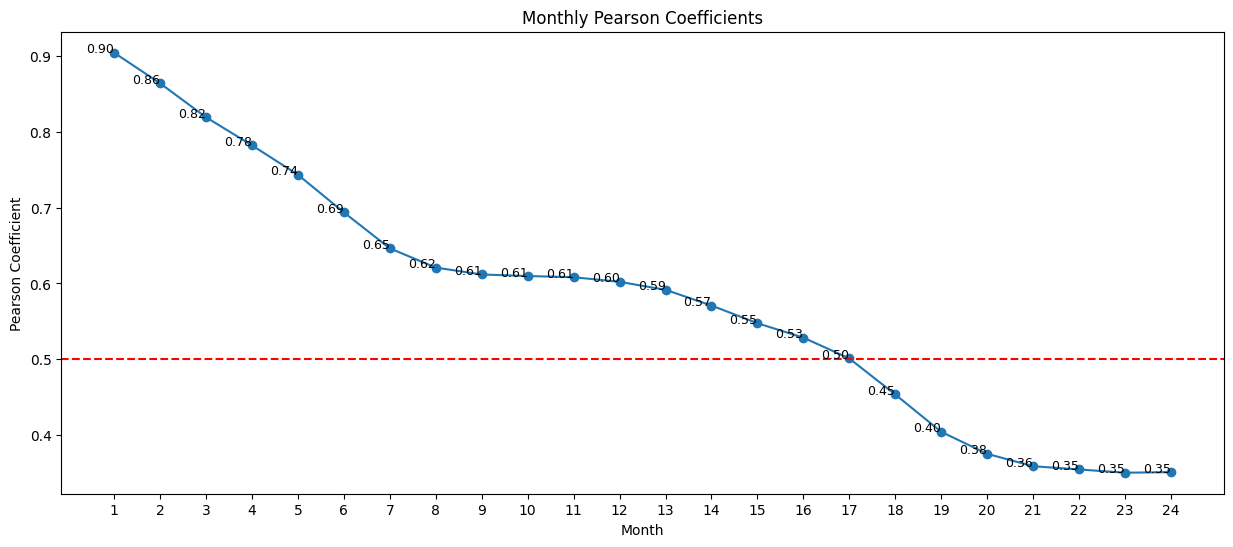

In [103]:
# 将月份和皮尔逊相关系数放入列表中，用于绘图
months = range(1, 25)  # 月份范围从1到24
pearson_coefficients = pearson_coefficients_monthly

# 绘制折线图
plt.figure(figsize=(15, 6))
plt.plot(months, pearson_coefficients, marker='o', linestyle='-')
plt.title('Monthly Pearson Coefficients')
plt.xlabel('Month')
plt.ylabel('Pearson Coefficient')
plt.xticks(range(1, 25))  # 设置 x 轴刻度为月份

# 在纵轴0.5的位置绘制一条水平线
plt.axhline(y=0.5, color='r', linestyle='--')

# 显示每个数据点的实际值
for month, coeff in zip(months, pearson_coefficients):
    plt.text(month, coeff, f'{coeff:.2f}', fontsize=9, ha='right')

plt.show()


In [ ]:
maxYnino_test[0][22].

In [ ]:
maxXnino_test =  X_train[2258:2259, :] 
maxYnino_test = y_train[2258:2259, :]

In [ ]:
maxXnino_test =  X_train[800:1000, :] 
maxYnino_test = y_train[800:1000, :]

In [42]:
graphs_test1_com = []
graphs_label1_com = []
#构造测试集
for X,Y in zip(maxXnino_test,maxYnino_test):
    g_com1 = dgl.graph((graph_data_np[0], graph_data_np[1]))
    g_com1.ndata['feature'] = X
    graphs_label1_com.append(Y)
    graphs_test1_com.append(g_com1)
dataset_com = GraphDataset(graphs_test1_com,graphs_label1_com)
loader_test_com = DataLoader(dataset_com, batch_size=1, shuffle=False, drop_last=False,collate_fn=collate_fn)

NameError: name 'maxXnino_test' is not defined

In [ ]:
model.eval()  # 设置模型为测试模式

out_list_test_com = []
labels_list_test_com = []

for batch in loader_test_com:
    for S in state:
        for s in S:
            s.detach_()

    input_data, labels = batch
    input_data = input_data.to(device)

    with torch.no_grad():  # 在测试阶段不需要计算梯度
        out, state = model(input_data, input_data.ndata['feature'], state)
        out = out.squeeze()

    # 收集out和labels的数据
    out_list_test_com.append(out.detach().cpu().numpy())
    labels_list_test_com.append(labels.detach().cpu().numpy())


In [ ]:
out_list_test_com

In [ ]:
pre_12 = [arr[:12] for arr in out_list_test_com ]

In [ ]:
label_12 = [arr[:12] for arr in labels_list_test_com ]

In [ ]:
pre12 = np.concatenate(pre_12)
label12 = np.concatenate(label_12)

In [ ]:
label12

In [ ]:

# 将张量从CUDA移动到CPU，并转换为NumPy数组
# out = out.cpu().numpy()

# 假设labels是索引
# 绘制图表
plt.figure(figsize=(10, 6))
plt.plot( pre12, label='pre12', linestyle='-')
plt.plot(label12, label='label12', linestyle='-')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison between Out and Labels')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
model = GCN_LSTM(input_size,hidden_size,num_classes,2,final_hidden_size).to(device)
state=[]
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss() # 或者根据你的任务选择其他损失函数

out_list = []
labels_list = []
for epoch in range(40):  # 假设训练3个epoch
    model.train()
    for batch in loader_train:
        for S in state:
            for s in S:
                s.detach_()      #这里需要注意，我们在使用LSTM进行计算时，通常需要使用这个来将之前的state使用detach避免计算多余的梯度
        #batch = batch.to(device)
        input_data, labels = batch
        input_data = input_data.to(device)
        optimizer.zero_grad()
        out, state = model(input_data, input_data.ndata['feature'], state)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        
         # 收集out和labels的数据
        out_list.append(out.detach().cpu().numpy())
        labels_list.append(labels.detach().cpu().numpy())
    print(f'Epoch [{epoch+1}/3] , train-Loss: {loss.item()}')
    
plt.figure()
plt.title('Fitting Curve')
for i in range(len(out_list)):
    plt.plot(out_list[i], label=f'Epoch {i+1}: out')
    plt.plot(labels_list[i], label=f'Epoch {i+1}: labels')
plt.legend()
plt.show()

In [ ]:
ds = xr.open_dataset(r'D:\ENSO\enso_data\ziyong\feature_data6.9.nc')

In [ ]:
file_path = r"D:\ENSO\enso_data\ziyong\label_datanino3.4.npy"

# 使用 numpy 的 load 函数加载数据
label_array = np.load(file_path)

In [ ]:
label_array.shape

In [ ]:
soda_features = ds.variables['feature_data'][:]  # 获取特征数据
soda_features = torch.tensor(soda_features.values,dtype=torch.float32)

In [ ]:
labelSODA_file_path = r'D:\ENSO\enso_data\enso_round1_train_20210201\SODA_label.nc'
wild_soda_label = xr.open_dataset(label_file_path)

def extract_yearly_data(label_data, months_to_keep=24):
    yearly_data = label_data['nino'].values  # 获取原始数据的值
    num_years = yearly_data.shape[0]
    months_per_year = yearly_data.shape[1]
    num_remaining_months = months_per_year - months_to_keep
    
    # 初始化用于存储结果的数组
    data_y = np.zeros((num_years, months_to_keep))
    
    for year_idx in range(num_years):
        # 从当前年份的第 (months_to_keep) 个月开始提取数据
        start_month_idx = num_remaining_months
        end_month_idx = start_month_idx + months_to_keep
    
        # 检查当前年份是否有足够的数据
        if end_month_idx <= months_per_year:
            # 提取当前年份后面24个月的数据
            yearly_data_slice = yearly_data[year_idx, start_month_idx:end_month_idx]
        
            # 将提取的数据存储到结果数组中
            data_y[year_idx, :] = yearly_data_slice
        else:
            # 如果当前年份的数据不足24个月，则将剩余位置填充为 0
            data_y[year_idx, :months_per_year - start_month_idx] = yearly_data[year_idx, start_month_idx:]
    
    return data_y
soda_label = extract_yearly_data(wild_soda_label)
# 打印结果数组的形状
print("Shape of data_y:", soda_label.shape)

In [ ]:
model.eval()  # 设置模型为测试模式

out_list_test = []
labels_list_test = []

for batch in loader_sodatest:
    for S in state:
        for s in S:
            s.detach_()

    input_data, labels = batch
    input_data = input_data.to(device)

    with torch.no_grad():  # 在测试阶段不需要计算梯度
        out, state = model(input_data, input_data.ndata['feature'], state)
        out = out.squeeze()

    # 收集out和labels的数据
    out_list_test.append(out.detach().cpu().numpy())
    labels_list_test.append(labels.detach().cpu().numpy())
